<a href="https://colab.research.google.com/github/meixinzhang/rigid-moving-objects/blob/main/rigid-moving-object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Detection and Segmentation of Rigidly Moving Objects

By Meixin Zhang, Yufeng Li

### *Abstract*

So far in the course, all of our segmentation work had been done with some supervision (seeds provided by user input). However, with two pictures that contains moving objects going through different motions, we may use epipolar geometry to find some feature points of the image are transformed using different essencial matrices. Given these feature points, we can apply semi-supervised techniques for segmentation. As there has been no user-input in this process, we are able to detect and perform segmentation on moving objects in images without supervision.

In this project, our approach is that we will first use UFL-based algorithm covered in class to detect multiple essential matrix-based models that ideally should classify feature points for different moving objects into different classes. This step allows us to assign detected features to classes without supervision and gives us some seeds that are required for segmentation. Then we use graph cut to perform segmentation of the moving objects based on the labeled feature points in the first step. (TODO)


### Team Members and Contributions

This cell should contain an itemized list of all team members. Each item (bullet) should start with a name and detail this person's contributions. 

- Meixin: Meixin was responsible for finding approapriate images for the project, implementing feature detection and matching functions (other functions in `mylibs/structure_from_motion_lib`) as well as graph-cut segmentation implementation . Meixin was also responsible for majority of the write-up and cleaning and structuring the code of this project.

- Yufeng: Yufeng was responsible for majority of the UFL implementation in `mylibs/structure_from_motion_lib` and feature classification implementation in addition to the write-up explaining the UFL implementation. Yufeng also helped with finding images for the project.


### Code Libraries

You should also have a separate cell titled code libraries acknowledging all external code libraries "essential" for your project. You should explain the importance of each such library for your project. 

If these libraries are not installed with the default anaconda package, provide installation instructions/links or include the necessary files in extlibs subdirectory. 

If needed, for better organization and clarity of your project you can write your own code libraries that should be summarized in this section as well. The corresponding (.py) files should be included in mylibs subdirectory. For group projects, you can refer to your team's libraries in the earlier "contributions" section. 

The essential libraries for this project are as follows:

(Used in `structure_from_motion_lib`)
- numpy
- skimage.feature.corner_harris, skimage.feature.corner_peaks
- skimage.feature.BRIEF, skimage.feature.match_descriptors
- skimage.transform.EssentialMatrixTransform

TODO

In [76]:
# Packages
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.image as image
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from skimage.feature import plot_matches
from skimage.transform import EssentialMatrixTransform
from skimage.color import rgb2gray

# Our Libraries 
from mylibs.structure_from_motion_lib import (
    get_matched_keyppoints, 
    matchedpoints_to_pairpoints, 
    camera_calib_nomalization,
    #estimate_ufl,
)

from mylibs.my_graph_cut import MaskBuilder, MyGraphCuts

## Implementation

(TODO: delete) 

You can detect multiple fundamental matrices while matching sparse features (Topics 6-7) and integrate these into loss functions for dense segmentation (topic 9). Essentially, this can be implemented as a combination of methods in HW3 and HW4. You can use any (pairs of) images for this project

First we read in two images with multiple rigidly moving objects. (Source: KITTI-SF image_02 folder)

We have found that in the dataset documentation that the camera calibration of the images is 

$$
K = \begin{bmatrix}
9.597910 e^{02} & 0 & 6.960217 e^{02} \\
0 & 9.569251 e^{02} & 2.241806 e^{02} \\
0 & 0 & 1
\end{bmatrix}
$$

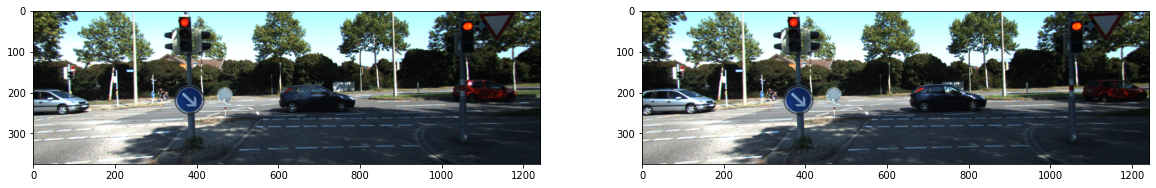

In [2]:
%matplotlib inline

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/car1_left.png")
imR = image.imread("images/car1_right.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# using K_02 from calibration.txt
K = 1.0e+02 * np.array([[9.597910,        0, 6.960217],
                        [       0, 9.569251, 2.241806],
                        [       0,        0,    0.010]])

plt.figure(0,figsize = (20, 8))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

### Structure from Motion Using UFL and Epipolar Geometry

##### Step 1: Feature Detection and Matching
Detect features on the given pictures using Harris corner detector and match the features on the two images using BRIEF descriptor.

the number of features in images 1 and 2 are   249 and   249
the number of matches is 199


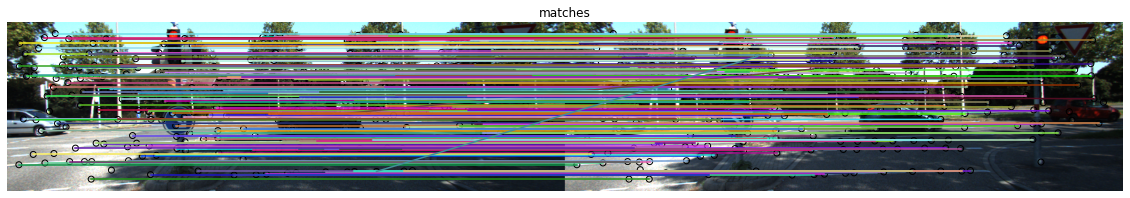

In [3]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL, keypointsR, matchesLR = get_matched_keyppoints(imLgray, imRgray)

fig = plt.figure(2, figsize = (20, 8))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

#### Step 2: Camera Normalization and Essential Matrix estimation using UFL

Recall that normalization of camera in the two images is given by multiplying the points by $K^{-1}$, where $K$ is the calibration parameters of the camera.


In [4]:
ptsL_inv, ptsR_inv = matchedpoints_to_pairpoints(keypointsL, keypointsR, matchesLR)
# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arra
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL, ptsR = ptsL_inv[:,[1, 0]], ptsR_inv[:,[1, 0]]

n_ptsL = camera_calib_nomalization(ptsL, K)
n_ptsR = camera_calib_nomalization(ptsR, K)

The UFL method of estimating multiple essential matrices we implemented is the method described in Lecture 6. The `estimate_ufl` function below accepts as inputs an array of source  points `src_pts` and an array of destination points `dst_pts`, along with parameters $K$, $\gamma$ and $T$ that corresponds to the variables used in slides 65 to 69 of Lecture 6. The lengths of the `src_pts` and `dst_pts` array must be the same.

Let $N$ be the length of the `src_pts` and `dst_pts` arrays. Then, `estimate_ufl` returns a pair `(result_models, pts_to_models)` where `result_models` is a list of homographies and `pts_to_models` is a list of length $N$ such that each `pts_to_models[i]` refers to an index in `result_models`. Together, `(result_models, pts_to_models)` describe a correspondence between the input `src_pts, dst_pts` and  homographies between various subsets o fthese points. The correspondence is described in the following manner:

  - If `pts_to_models[i] = -1` then the source point `src_pts[i]` and `dst_pts[i]` are outliers
  - Otherwise, `result_models[pts_to_models[i]]` is a homography that maps `src_pts[i]` to `dst_pts[i]`
 
Therefore, the `src_pts[k], dst_pts[k]` is an inlier the $i$-th model `result_models[i]` precisely when `pts_to_models[k] = i`.
 
The `estimate_ufl` function is implemented in the following steps:

  1. Randomly choose $K$ subsets of size 8 to compute $K$ homographies where each homography perfectly fits the corresponding 8 chosen points.
  2. (a) Associate each `(src_pts[i], dst_pts[i])` to the nearest model in the currently maintained list of models. The points associated to each model are the inliers for that model. If a model was found to have no inliers, then this model is removed from the list of models.
     (b) Re-estimate each model using the inliers assigned in step (a).
  3. Apply the UFL heuristic by removing the models whose maintaince costs are too high. The maintaince cost of a model $H$ is defined to be the sum of the distances of the inlier points to $H$ added to the base maintence cost $\gamma$. Here, if $(s,d) = $`(src_pts[i], dst_pts[i])` is an inlier of $H$ then its distance to $H$ is defined by $\lVert d - Hs \rVert$. On the other hand, we also compute the removal cost of $H$, which is the sum of distances of its inliers to the next closest model except $H$. If the removal cost is lower than the maintaince cost, the model $H$ is removed.
  4. Iterate steps 2 and 3 until the energy of the system converges. Here, the energy of the system is defined as the sum of distances of each point to their respective model, with an additional cost $\gamma L$ where $L$ is the length of the current list of models.


In [68]:
class UFL:
    def __init__(self, K=100, gamma=0.01, T=1):
        self.K = K
        self.gamma = gamma 
        self.T = T

    def initialize_models(self, src_pts, dst_pts):
        assert len(src_pts) == len(dst_pts)
        num_pts = len(src_pts)
        models = []
        
        for i in range(self.K) :
        # Randomly choose 8 points
            random_idx = np.random.choice(num_pts, 8, replace=True)
            src_random = src_pts[random_idx]
            dst_random = dst_pts[random_idx]
            # Fit a homography through them
            EMT = EssentialMatrixTransform()
            if EMT.estimate(src_random, dst_random):
                models.append(EMT.params)
        # Remove duplicates in the initial set of models
        models = np.unique(np.array(models), axis=0)
        return models
    
    def reestimateModels(self, models, src_pts, dst_pts, iter_num=None):
        """ Assign points to closest models and reestimate different models (step 2) """
        assert len(src_pts) == len(dst_pts)
        num_pts = len(src_pts)
        dst_hom = np.hstack((dst_pts, np.ones((num_pts,1))))
        src_hom = np.vstack((src_pts.T, np.ones(num_pts)))

        # 2a. Nearest model for each point
        nearest_models = np.full(num_pts, fill_value=-1)
        # Nearest distances for each point
        distances = np.full(num_pts, fill_value=np.Inf)
        
        # Find nearest model for each point
        for i in range(len(models)) :
            # Distances for each point to the current model
            model_dists = np.linalg.norm(dst_hom - (models[i] @ src_hom).T, axis=1)
            # Update points where the current model has smaller distance
            nearest_models[np.where((model_dists < distances) & (model_dists < self.T))] = i
            # Update distances
            distances = np.minimum(distances, model_dists)

        if iter_num :
            print(f'After finding nearest model for each point...')
            print(f'nearest_models = {nearest_models}')
            print(f'model_dists = {model_dists}')

        result_models = []
        pts_to_models = np.full(num_pts, fill_value=-1)
        # Map each model to its list of points
        model_pts_masks = [] 
        # Readjust parameters for each model to better fit the inliers
        for i in range(len(models)):
            # The inlier index
            inlier_idx = np.where(nearest_models == i)
            # Skip if no inliers
            if len(inlier_idx[0]) < 8 :
                pts_to_models[inlier_idx] = -1
                if iter_num :
                    print(f'Less than 8 inliers for model {i}, skipping...')
                continue

            # Inlier points
            src_inliers = src_pts[inlier_idx]
            dst_inliers = dst_pts[inlier_idx]
            # Make the model more precise by re-estimating using only the inliers
            EMT = EssentialMatrixTransform()
            if EMT.estimate(src_inliers, dst_inliers):
                pts_to_models[inlier_idx] = len(result_models)
                print(f'Setting points {inlier_idx} to have model {len(result_models)}')
                result_models.append(EMT.params)
                model_pts_masks.append(inlier_idx)
            else :
                print('re-estiamte failed')
                pts_to_models[inlier_idx] = -1
        
        return result_models, pts_to_models, model_pts_masks

    def removeModels(self, src_pts, dst_pts, models, pts_to_models, model_pts_masks):
        """ removing lines L that are not worth keeping (step 3) """
        assert len(src_pts) == len(dst_pts)
        num_pts = len(src_pts)
        dst_hom = np.hstack((dst_pts, np.ones((num_pts,1))))
        src_hom = np.vstack((src_pts.T, np.ones(num_pts)))

        # 3. Decide whether or not to keep each model
        assert len(models) == int(max(pts_to_models))+1
        for i in range(len(models)):
            print('----------')
            # Points assigned to this model
            model_pts_mask = model_pts_masks[i]
            assert len(model_pts_mask[0]) >= 8, f"Less than 8 inliers for model {i}"
            print(f'inlier points index for model {i} is {model_pts_mask}')
            # The cost of keeping this model is the cost of assigning points
            # to this model plus the maintenance gamma
            model_dists = np.linalg.norm(dst_hom - (models[i] @ src_hom).T, axis=1)[model_pts_mask]
            keep_cost = np.sum(model_dists) + self.gamma
            print(f'cost to keep model {i} is {keep_cost}')

            # Find the nearest model for each point excluding the current model
            other_model_dists = np.full(num_pts, fill_value=np.Inf)
            # Nearest model for each point after the current model is removed
            other_nearest_models = pts_to_models
            for j in range(len(models)) :
                # Skip if it's the current model under consideration
                if j == i :
                    continue
                model_dists_j = np.linalg.norm(dst_hom - (models[j] @ src_hom).T, axis=1)
                # Distances for each point to the model
                other_nearest_models[np.intersect1d(np.where(model_dists_j < other_model_dists)[0], model_pts_mask[0])] = j
                other_model_dists = np.minimum(other_model_dists, model_dists_j)
            # Cost of removing the model
            remove_cost = np.sum(other_model_dists[model_pts_mask])
            #print(f'distances to nearest model after removing model {i} = ')
            #print(remove_model_dists)
            print(f'cost to remove model {i} is {remove_cost}')
            # Remove the model if the cost of keeping is greater
            if remove_cost < keep_cost :
                print(f'remove model {i}')
                pts_to_models[model_pts_mask] = other_nearest_models[model_pts_mask]
                print(f'pts_to_models = {pts_to_models}')

        # Calculate the energy of the current configuration
        model_dists = np.linalg.norm(dst_hom - (models[i] @ src_hom).T, axis=1)[np.where(pts_to_models > -1)]
        energy = np.sum(model_dists)
        return models, pts_to_models, energy

    def estimate_ufl(self, src_pts, dst_pts):
        """
        Estimates a homography from src_pts to dst_pts using the UFL method.
        K is the number of initial points to choose from
        """
        iter_num = 0
        energy = np.Inf
        initial_model = self.initialize_models(src_pts, dst_pts)
        result_models, pts_to_models, model_pts_masks = self.reestimateModels(initial_model, src_pts, dst_pts, iter_num=iter_num)
        while iter_num >= 0 :
            print('====================================================================================================')
            iter_num = iter_num+1
            result_models_update, pts_to_models_update, energy_update = self.removeModels(
                src_pts, dst_pts, result_models, pts_to_models, model_pts_masks)
            result_models_update, pts_to_models_update, model_pts_masks = self.reestimateModels(result_models_update, src_pts, dst_pts, iter_num=iter_num)
            print(f'energy = {energy_update}, num classes = {len(np.unique(pts_to_models_update))}')
            # print(f'result_models = ')
            # print(result_models_update)
            # print(f'pts_to_models = ')
            # print(pts_to_models_update)

            if energy_update < energy :
                energy = energy_update
                result_models, pts_to_models = result_models_update, pts_to_models_update
            else:
                return result_models, pts_to_models

In [53]:
def estimate_ufl(src_pts, dst_pts, K=100, gamma=0.01, T=1):
    """
    Estimates a homography from src_pts to dst_pts using the UFL method.
    K is the number of initial points to choose from
    """
    assert len(src_pts) == len(dst_pts)
    num_pts = len(src_pts)
    # Initial set of models
    models = []

    # 1. Randomly choose K lines
    for i in range(K) :
        # Randomly choose 8 points
        random_idx = np.random.choice(num_pts, 8, replace=True)
        src_random = src_pts[random_idx]
        dst_random = dst_pts[random_idx]
        # Fit a homography through them
        EMT = EssentialMatrixTransform()
        if EMT.estimate(src_random, dst_random):
            models.append(EMT.params)
    # Remove duplicates in the initial set of models
    models = np.unique(np.array(models), axis=0)

    # Homogeneous coordinates
    dst_hom = np.hstack((dst_pts, np.ones((num_pts,1))))
    src_hom = np.vstack((src_pts.T, np.ones(num_pts)))

    # Iteration of steps 2 and 3
    def iterate(models, iter_num=None):
        # 2a. Nearest model for each point
        nearest_models = np.full(num_pts, fill_value=-1)
        pts_to_models = np.full(num_pts, fill_value=-1)
        # Nearest distances for each point
        distances = np.full(num_pts, fill_value=np.Inf)

        if iter_num :
            print(f'iter_num = {iter_num}')
            print(f'models = {models}')
            #print(f'nearest_models = {nearest_models}')
        
        # Find nearest model for each point
        for i in range(len(models)) :
            # Distances for each point to the current model
            model_dists = np.linalg.norm(dst_hom - (models[i] @ src_hom).T, axis=1)
            # Update points where the current model has smaller distance
            nearest_models[np.where((model_dists < distances) & (model_dists < T))] = i
            # Update distances
            distances = np.minimum(distances, model_dists)

        if iter_num :
            print(f'After finding nearest model for each point...')
            print(f'nearest_models = {nearest_models}')
            print(f'model_dists = {model_dists}')
        
        result_models = []
        # Map each model to its list of points
        model_pts_masks = [] 
        # Readjust parameters for each model to better fit the inliers
        for i in range(len(models)):
            # The inlier index
            inlier_idx = np.where(nearest_models == i)
            # Skip if no inliers
            if len(inlier_idx[0]) < 8 :
                pts_to_models[inlier_idx] = -1
                if iter_num :
                    print(f'Less than 8 inliers for model {i}, skipping...')
                continue

            # Inlier points
            src_inliers = src_pts[inlier_idx]
            dst_inliers = dst_pts[inlier_idx]
            # Make the model more precise by re-estimating using only the inliers
            EMT = EssentialMatrixTransform()
            if EMT.estimate(src_inliers, dst_inliers):
                pts_to_models[inlier_idx] = len(result_models)
                print(f'Setting points {inlier_idx} to have model {len(result_models)}')
                result_models.append(EMT.params)
                model_pts_masks.append(inlier_idx)
            else :
                print('re-estiamte failed')
                pts_to_models[inlier_idx] = -1
        
        #print(len(result_models))
        #print(f're-estimated result_models = {result_models}')
        print(f'pts_to_models = {pts_to_models}')
        print(result_models)
        
        # 3. Decide whether or not to keep each model
        assert len(result_models) == int(max(pts_to_models))+1
        for i in range(len(result_models)):
            print('----------')
            # Points assigned to this model
            model_pts_mask = model_pts_masks[i]
            assert len(model_pts_mask[0]) >= 8, f"Less than 8 inliers for model {i}"
            print(f'inlier points index for model {i} is {model_pts_mask}')
            # The cost of keeping this model is the cost of assigning points
            # to this model plus the maintenance gamma
            model_dists = np.linalg.norm(dst_hom - (models[i] @ src_hom).T, axis=1)[model_pts_mask]
            keep_cost = np.sum(model_dists) + gamma
            print(f'cost to keep model {i} is {keep_cost}')

            # Find the nearest model for each point excluding the current model
            other_model_dists = np.full(num_pts, fill_value=np.Inf)
            # Nearest model for each point after the current model is removed
            other_nearest_models = pts_to_models
            for j in range(len(result_models)) :
                # Skip if it's the current model under consideration
                if j == i :
                    continue
                model_dists_j = np.linalg.norm(dst_hom - (models[j] @ src_hom).T, axis=1)
                # Distances for each point to the model
                other_nearest_models[np.intersect1d(np.where(model_dists_j < other_model_dists)[0], model_pts_mask[0])] = j
                other_model_dists = np.minimum(other_model_dists, model_dists_j)
            # Cost of removing the model
            remove_cost = np.sum(other_model_dists[model_pts_mask])
            #print(f'distances to nearest model after removing model {i} = ')
            #print(remove_model_dists)
            print(f'cost to remove model {i} is {remove_cost}')
            # Remove the model if the cost of keeping is greater
            if remove_cost < keep_cost :
                print(f'remove model {i}')
                pts_to_models[model_pts_mask] = other_nearest_models[model_pts_mask]
                print(f'pts_to_models = {pts_to_models}')

        # Calculate the energy of the current configuration
        model_dists = np.linalg.norm(dst_hom - (models[i] @ src_hom).T, axis=1)[np.where(pts_to_models > -1)]
        energy = np.sum(model_dists)
        return result_models, pts_to_models, energy

    result_models, pts_to_models, energy = iterate(models)
    print(f'energy = {energy}, num classes = {len(np.unique(pts_to_models))}')
    print(f'result_models')
    print(result_models)
    print(f'pts_to_models')
    print(pts_to_models)
    iter_num = 0
    while iter_num >= 0 :
        print('====================================================================================================')
        iter_num = iter_num+1
        models_update, pts_to_models_update, energy_update = iterate(result_models, iter_num=iter_num)
        print(f'energy = {energy_update}, num classes = {len(np.unique(pts_to_models_update))}')
        print(f'result_models = ')
        print(models_update)
        print(f'pts_to_models = ')
        print(pts_to_models_update)

        if energy_update < energy :
            energy = energy_update
            result_models, pts_to_models = models_update, pts_to_models_update
        else:
            return result_models, pts_to_models

Setting points (array([ 28,  29,  42,  43,  50,  70,  73,  76,  94, 155]),) to have model 0
Setting points (array([  1,   7,  10,  11,  15,  17,  20,  26,  39,  60,  64,  65,  68,
        84, 100, 107, 113, 118, 119, 123, 126, 141, 149, 180]),) to have model 1
Setting points (array([  2,  13,  36,  41,  44,  46,  52,  55,  58,  62,  63,  66,  67,
        71,  74,  77,  88,  97, 103, 105, 109, 121, 150, 174, 177]),) to have model 2
Setting points (array([132, 148, 156, 162, 168, 172, 175, 179, 183]),) to have model 3
Setting points (array([ 35,  38,  48,  57,  61,  78,  86,  87, 131]),) to have model 4
Setting points (array([ 19,  22,  69,  75, 143, 184, 186, 192]),) to have model 5
Setting points (array([ 98, 104, 111, 114, 134, 138, 139, 178, 194]),) to have model 6
Setting points (array([  5,   6,  18,  24,  25,  31,  56,  59,  72,  90,  91, 106, 145,
       157, 185]),) to have model 7
----------
inlier points index for model 0 is (array([ 28,  29,  42,  43,  50,  70,  73,  76,  94,

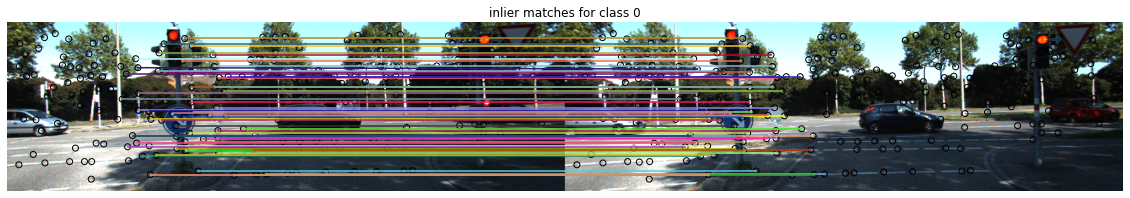

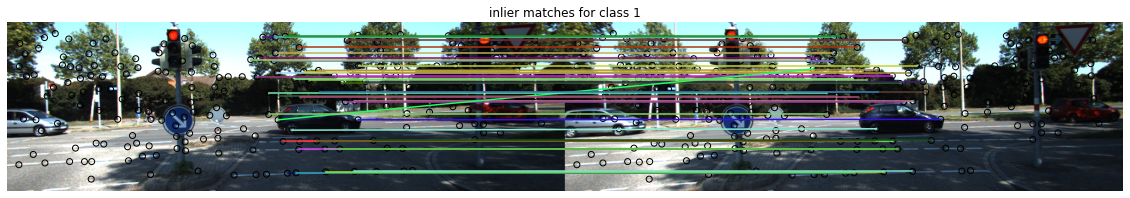

In [69]:
# robustly estimate essential matrices using normalized points and UFL
# E_ufl_trans, E_ufl_models = estimate_ufl(n_ptsL, n_ptsR, K = 100, gamma = 0.01, T = 10)

UFLEstimator = UFL(K=100, gamma=0.01, T=10)
E_ufl_trans, E_ufl_models = UFLEstimator.estimate_ufl(n_ptsL, n_ptsR)
num_inliers = len(np.where(E_ufl_models > -1)[0])
num_classes = int(len(np.unique(E_ufl_models[np.where(E_ufl_models > -1)])))
print ('the number of classes found by ufl is {:d}'.format(num_classes))
print ('the number of ufl inliers is {:d}'.format(num_inliers))

# Show the inliers for the different classes
for i in range(num_classes):
    E_i = E_ufl_trans[i]    # Singular values for E
    E_inliers_i = np.where(E_ufl_models == i)[0]

    ind = np.ogrid[:n_ptsL.shape[0]]
    EmatchesRansac = np.column_stack((ind[E_inliers_i],ind[E_inliers_i]))

    fig = plt.figure(5+i,figsize = (20, 8))
    axA = plt.subplot(111)
    axA.set_title(f"inlier matches for class {i}")
    plt.gray()
    # NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
    plot_matches(axA, imL, imR, ptsL_inv, ptsR_inv, EmatchesRansac)
    axA.axis('off')
    plt.show()

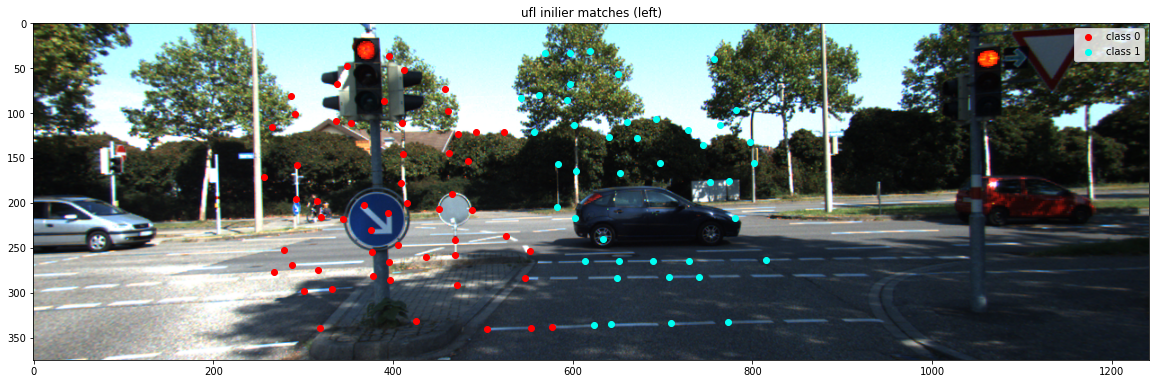

In [70]:
# Maps object points to colours
c_map = plt.cm.get_cmap('hsv', num_classes+1)

ufl_l_fig = plt.figure(12,figsize = (20, 8))
ufl_l_ax = plt.subplot(111)
ufl_l_ax.set_title("ufl inilier matches (left)")
ufl_l_ax.imshow(imL)

for i in range(num_classes):
    class_colour = c_map(i)
    class_pts = ptsL[np.where(E_ufl_models == i)]
    ufl_l_ax.scatter(x=class_pts[:,0], y=class_pts[:,1], color=class_colour, label=f'class {i}')
    
ufl_l_ax.legend()


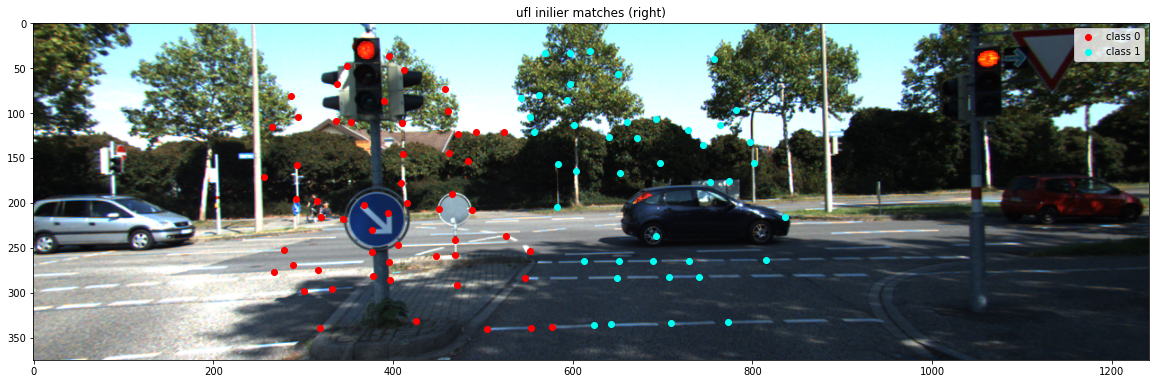

In [71]:
ufl_r_fig = plt.figure(13,figsize = (20, 8))
ufl_r_ax = plt.subplot(111)
ufl_r_ax.set_title("ufl inilier matches (right)")
ufl_r_ax.imshow(imR)

for i in range(num_classes):
    class_colour = c_map(i)
    class_pts = ptsR[np.where(E_ufl_models == i)]
    ufl_r_ax.scatter(x=class_pts[:,0], y=class_pts[:,1], color=class_colour, label=f'class {i}')
    
ufl_r_ax.legend()

### Use the Classified Feature Points From UFL for Segmentation

Since the feature points from the previous section have been categorized, they can be used as seeds for segmentation.

you should implement graph cut algorithm for minimizing the loss (see slide 182 topic 9)
Iterative learning of color models, GrabCut: iterated graph cuts

$$ -\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda \sum_{pq\in N} w_{pq}\,[S_p \neq S_q] $$ 

$$ -\sum_p \log Pr(I_p\,|\,\theta_{S_p}) \;\;-\;\;\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda\sum_{pq\in N} w_{pq}\,[S_p \neq S_q] + |labels|$$ 

combining the seed loss (hard constraints for user-defined labels) and basic pair-wise regularization loss with "contrast-weights" $w_{pq} = \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ for 4-connected grid neighborhood. Note that the scalar (hyper-parameter) $\lambda$ controlling the regularization strength can be integrated into edge weights $\tilde{w}_{pq} = \lambda \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ (parameter $\lambda$ is primarily needed for the second milestone below). Terminal "t-links" for seed-points should make sure that such graph nodes can not be severed from the corresponding terminals.

You have to use "large-enough" finite cost t-links to enforce hard-constraints (user seeds) since "infinity" weight is not possible to implement. One can argue that $N\cdot \max \{\tilde{w}_{pq}\}\equiv N\lambda$ (number of neighbors at each point times the largest n-link weight) is sufficient.

multi-terminal graph cuts are needed for segmentation step [BVZ, PAMI 2001]

In [91]:
# assign outliers to class 0, and others to i+1
seed_mask_builder_left = MaskBuilder(imL.shape[0], imL.shape[1], MyGraphCuts.none_value)
for i in range(num_classes+1):
    class_pts = ptsL[np.where(E_ufl_models == i-1)]
    for pt in class_pts:
        seed_mask_builder_left.add_disk(pt[0], pt[1], 3, i)

gc = MyGraphCuts(imL, sigma=0.5, lam=50)
seed_mask_left = seed_mask_builder_left.get_mask()
final_seg = np.full(seed_mask_left.shape, fill_value=MyGraphCuts.none_value)
for i in range(num_classes):
    print('====================================================================================================')
    print("segmentation for class", i)
    class_i_mask = np.full(seed_mask_left.shape, fill_value=MyGraphCuts.none_value)
    class_i_mask[np.where(seed_mask_left == i)] = MyGraphCuts.obj_value
    class_i_mask[np.where((seed_mask_left != MyGraphCuts.none_value) & (seed_mask_left != i))] = MyGraphCuts.bgr_value
    seg_i = gc.compute_labels(class_i_mask)
    final_seg[np.where(seg_i == MyGraphCuts.obj_value)] = i

segmentation for class 0
segmentation for class 1


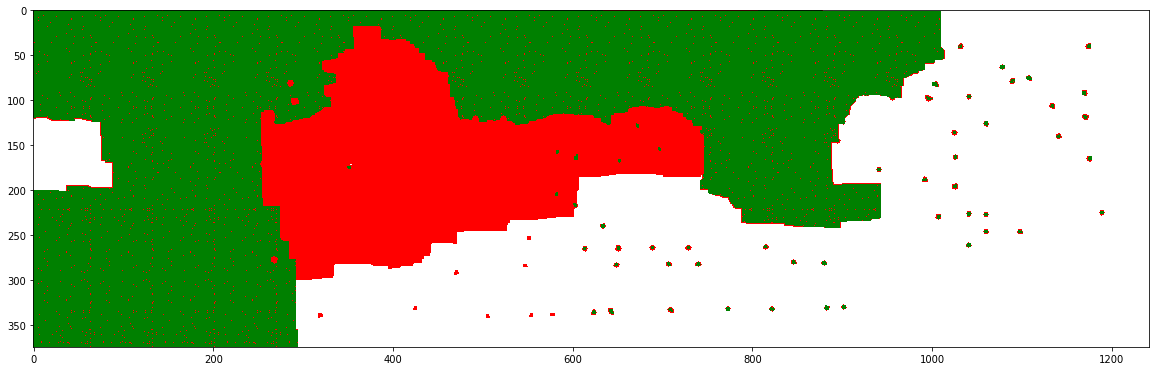

In [92]:
colors = ['red','green','blue']

fig,ax = plt.subplots(figsize=(20,8))
levels = range(len(colors))
cmap, norm = mpl.colors.from_levels_and_colors(levels, colors, extend='max')
mask_view = ax.imshow(final_seg, cmap=cmap, norm=norm)

## Conclusion


At the bottom of your notebook, you should include a cell with two-three paragraphs summarizing the conclusions of your project.